## LIMPEZA DOS DADOS

In [215]:
import pandas as pd
import tensorflow as tf
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt

# Carregando e fazendo visualizações iniciais
df = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
y = pd.read_csv("gender_submission.csv")
df.set_index('PassengerId')
y.set_index('PassengerId')
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [216]:
print(df.nunique()) # Verificando a quantidade de valores nulos


PassengerId    418
Pclass           3
Name           418
Sex              2
Age             79
SibSp            7
Parch            8
Ticket         363
Fare           169
Cabin           76
Embarked         3
dtype: int64


Aqui se pode verificar que não há discrepâncias claras de quantidade de valores categoricos parar as colunas categóricas

- Verificação dos valores nulos:

In [217]:
print(df.isna().sum()) # Verificando se há valores nulos

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Aqui vemos uma grande quantidade de valores nulos em Cabin, o que indica que remover a coluna seria uma boa escolha. Além disso, precisamos encontrar uma maneira de tratar as idades que estão faltando.

- Verificação das correlações:

C:\Users\renae\AppData\Local\Temp\ipykernel_11192\3269251083.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(corr.corr())


<Axes: >

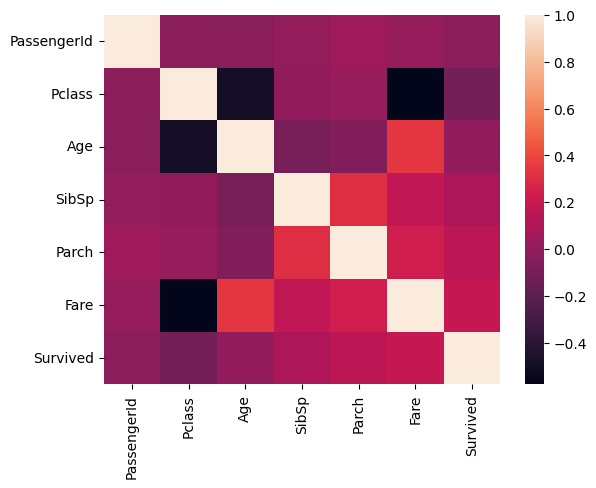

In [222]:
corr = df.join(y.set_index("PassengerId"), on='PassengerId')
sb.heatmap(corr.corr())

A partir do heatmap não foi possível encontrar boas correlações e nem mesmo uma boa coluna a partir da qual inferir os valores de idade que estão faltando no dataset original

- Verificação dos valores categóricos:

In [198]:
print(df.dtypes)

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


As colunas Ticket, Name e Cabin podem ser removidas por serem inerentemente irrelevantes. A coluna Embarked também não parece ser relevante para a análise final.

In [199]:
cols = ['Name', 'Cabin', 'Ticket', 'Embarked']
df.drop(cols, axis=1, inplace=True)
train.drop(cols, axis=1, inplace=True)
df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,892,3,male,34.5,0,0,7.8292
1,893,3,female,47.0,1,0,7.0000
2,894,2,male,62.0,0,0,9.6875
3,895,3,male,27.0,0,0,8.6625
4,896,3,female,22.0,1,1,12.2875


Agora, basta substituir os valores dos sexos para 0: male e 1: female. Por termos baixa cardinalidade, é possível usar um One-Hot Encoder

In [200]:
from sklearn.preprocessing import OneHotEncoder

In [201]:
hot_enc = OneHotEncoder()
df_hot = pd.get_dummies(df['Sex'])
train_hot = pd.get_dummies(train['Sex'])

df = df.drop(['Sex'], axis='columns')
train = train.drop(['Sex'], axis='columns')

df = pd.concat([df, df_hot], axis='columns')
train = pd.concat([train, train_hot], axis='columns')
df.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,female,male
0,892,3,34.5,0,0,7.8292,0,1
1,893,3,47.0,1,0,7.0000,1,0
2,894,2,62.0,0,0,9.6875,0,1
3,895,3,27.0,0,0,8.6625,0,1
4,896,3,22.0,1,1,12.2875,1,0


- Análise de Outliers

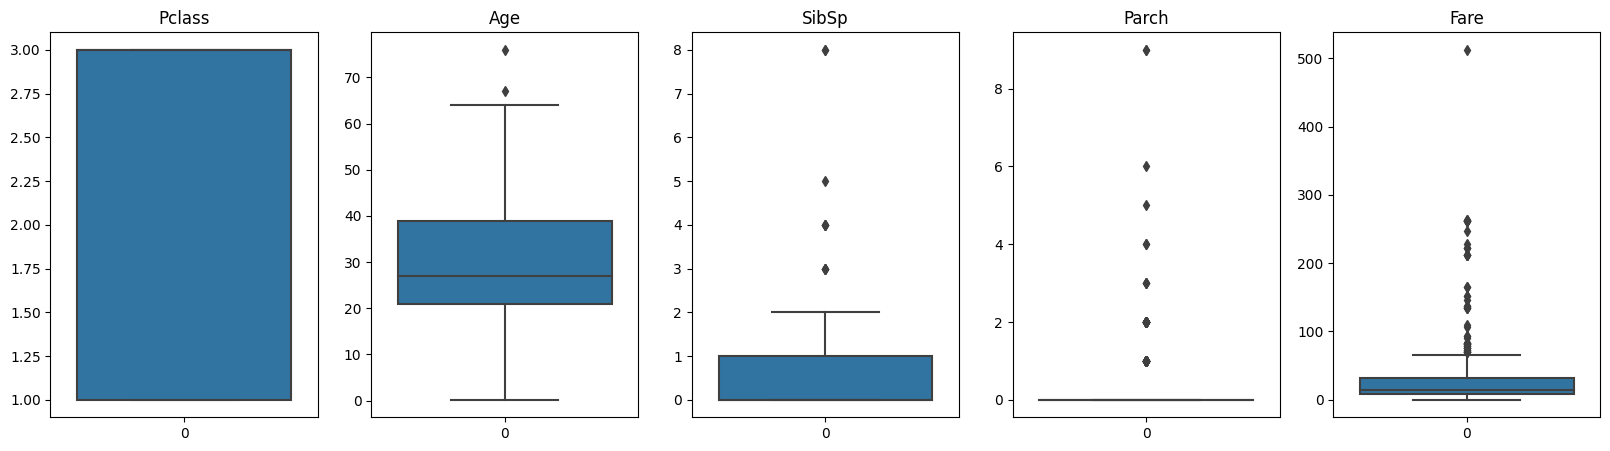

In [202]:
# Criando dataframe para verificar outliers
out = df.drop(['female', 'male', 'PassengerId'], axis=1)

fig, axs = plt.subplots(ncols=out.columns.size, figsize=(20,5))
for i in range(out.columns.size):
    sb.boxplot(data=out.iloc[:, i], ax=axs[i])
    axs[i].set_title(out.columns[i])
plt.show()

Aqui podemos ver que existem dois valores de outliers para a idade, alguns para SibSp e Parch e muitos para Fare. Nesse caso, não tendo descartado passenger anteriormente, talvez esse seja um bom motivo. Embora passageiros que tenham pago mais possam estar acomodadas em locais específicos que podem ter sido mais ou menos afetados, essa informação também deve estar representada em Pclass, no entanto, o mapa de correlação visto anteriormente nos diz que Fare tem uma das melhores relações com Survived, portanto talvez não seja razoável removê-la. À princípio, irei removê-la, mas também é possível realizar teste com a coluna.

In [203]:
df.drop('Fare', axis=1, inplace=True)

Por cautela, podemos verificar a contagem de passageiros para cada valor de SibSp e Parch a partir dos valores que estão fora dos desvios padrão:

In [204]:
print("Parch")
for i in range(1, df['Parch'].max()):
    print(f'{i}:', len(df[df['Parch'] == i]))

print("SibSp")
for i in range(2, df['SibSp'].max()):
    print(f'{i}:', len(df[df['SibSp'] == i]))
df.shape


Parch
1: 52
2: 33
3: 3
4: 2
5: 1
6: 1
7: 0
8: 0
SibSp
2: 14
3: 4
4: 4
5: 1
6: 0
7: 0


(418, 7)

 Aqui podemos ver que é razoável remover os outliers a partir de 3 em Parch e a partir de 3 em SibSp

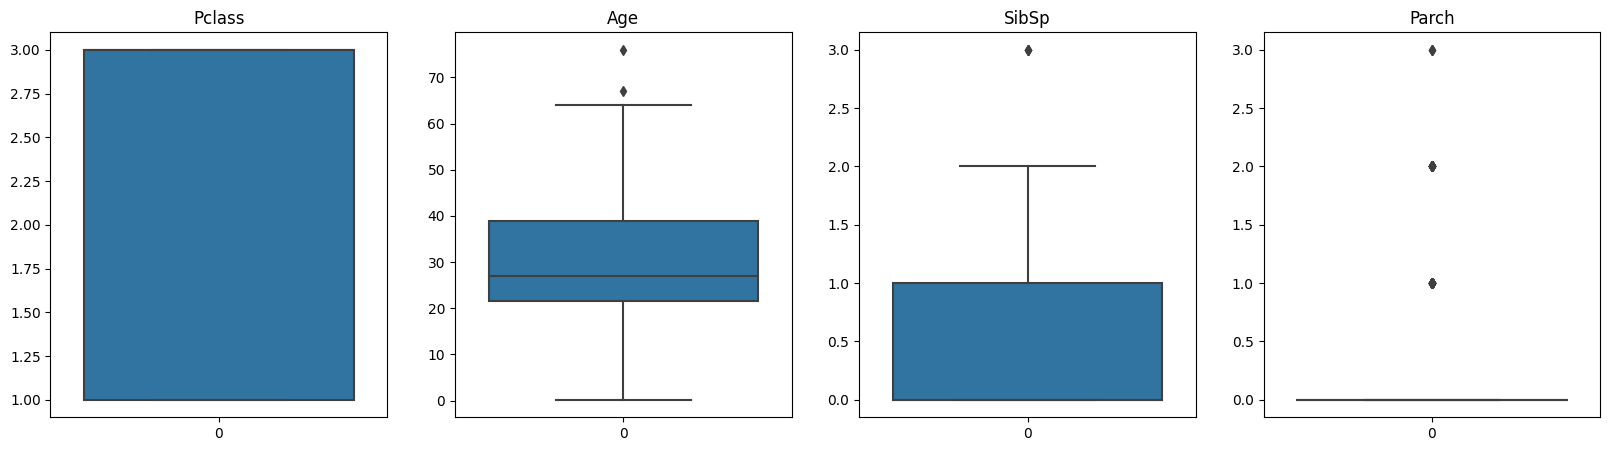

In [205]:
df = df[(df['Parch'] <= 3) & (df['SibSp'] <= 3)]
out = df.drop(['female', 'male', 'PassengerId'], axis=1)

fig, axs = plt.subplots(ncols=out.columns.size, figsize=(20,5))
for i in range(out.columns.size):
    sb.boxplot(data=out.iloc[:, i], ax=axs[i])
    axs[i].set_title(out.columns[i])
plt.show()

Assim removemos a maior parte dos outliers sem remover uma quantidade extremamente grande de linhas da tabela.

- Imputation

Por fim, precisamos encontrar uma forma de ajustar os valores perdidos de idade. À princípio, podemos imputar os valores com base na média.

In [206]:
from sklearn.impute import SimpleImputer

In [207]:
imputer = SimpleImputer()
df_imputed = pd.DataFrame(imputer.fit_transform(df))

# Devolvendo os nomes das colunas:
df_imputed.columns = df.columns
df_imputed.set_index('PassengerId')
print(df_imputed.head())
print(df_imputed.isna().sum())
print("Média idade: ", df['Age'].mean())
df = df_imputed

   PassengerId  Pclass   Age  SibSp  Parch  female  male
0        892.0     3.0  34.5    0.0    0.0     0.0   1.0
1        893.0     3.0  47.0    1.0    0.0     1.0   0.0
2        894.0     2.0  62.0    0.0    0.0     0.0   1.0
3        895.0     3.0  27.0    0.0    0.0     0.0   1.0
4        896.0     3.0  22.0    1.0    1.0     1.0   0.0
PassengerId    0
Pclass         0
Age            0
SibSp          0
Parch          0
female         0
male           0
dtype: int64
Média idade:  30.402476780185758


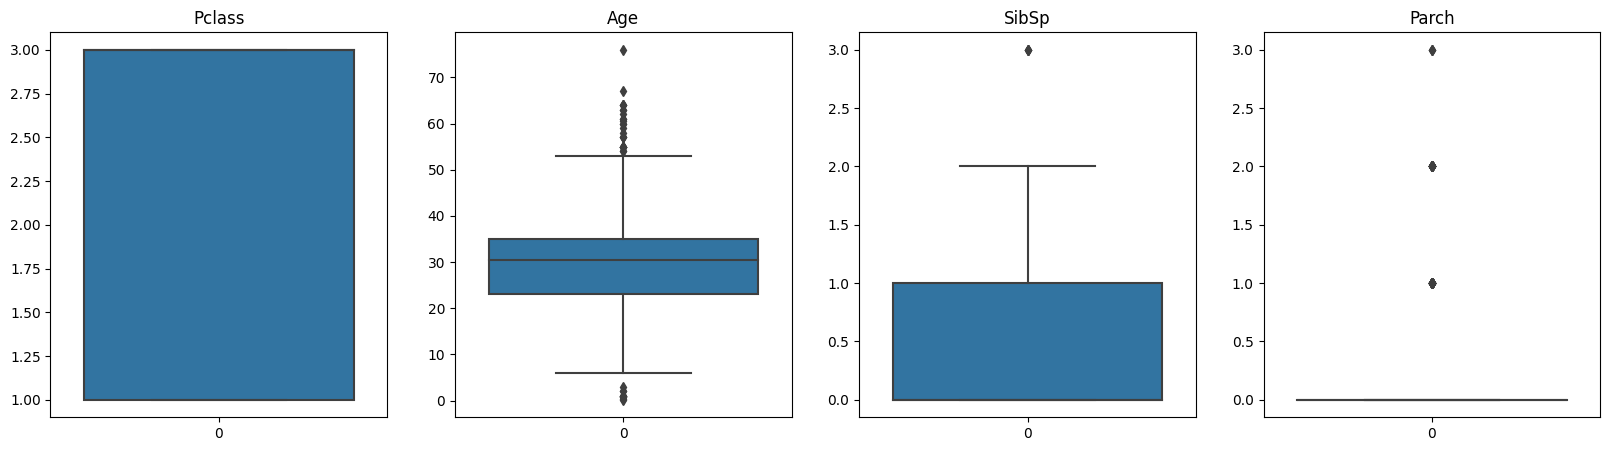

In [208]:
# Criando dataframe para verificar outliers
out = df.drop(['female', 'male', 'PassengerId'], axis=1)

fig, axs = plt.subplots(ncols=out.columns.size, figsize=(20,5))
for i in range(out.columns.size):
    sb.boxplot(data=out.iloc[:, i], ax=axs[i])
    axs[i].set_title(out.columns[i])
plt.show()

In [191]:
df['PassengerId'].astype(int)
df

,PassengerId,Pclass,Age,SibSp,Parch,female,male
0,892.0,3.0,34.500000,0.0,0.0,0.0,1.0
1,893.0,3.0,47.000000,1.0,0.0,1.0,0.0
2,894.0,2.0,62.000000,0.0,0.0,0.0,1.0
3,895.0,3.0,27.000000,0.0,0.0,0.0,1.0
4,896.0,3.0,22.000000,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...
400,1305.0,3.0,30.402477,0.0,0.0,0.0,1.0
401,1306.0,1.0,39.000000,0.0,0.0,1.0,0.0
402,1307.0,3.0,38.500000,0.0,0.0,0.0,1.0
403,1308.0,3.0,30.402477,0.0,0.0,0.0,1.0


Aqui temos a nova tabela pronta para ser treinada pelos modelos de Machine Learning.

# TREINANDO MODELOS